# DPGExplainer Saga Benchmarks — Episode 1: Iris

A practitioner-friendly walkthrough of Decision Predicate Graphs (DPG) using the classic Iris dataset. We train a small RandomForest, build a DPG, and interpret three key signals: Local Reaching Centrality (LRC), Betweenness Centrality (BC), and Communities.

## 1. Setup

In [7]:
%pip install --force-reinstall --no-deps git+https://github.com/Meta-Group/DPG.git

  Cloning https://github.com/Meta-Group/DPG.git to /tmp/pip-req-build-3ovrs98s
  Running command git clone --filter=blob:none --quiet https://github.com/Meta-Group/DPG.git /tmp/pip-req-build-3ovrs98s
  Resolved https://github.com/Meta-Group/DPG.git to commit 8ce9f7194e535ecc47777d8e7dc5d91e8b0daba0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dpg: filename=dpg-0.1.5-py3-none-any.whl size=30321 sha256=91f016f18f626d19451b83a2590e3f6249733ec57e601bf40a68c33e27c27491
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2qwysrr/wheels/42/6e/2f/472cc15363ec993fcef22376843c90658f58154dedcbbcdf39
Successfully built dpg
  Attempting uninstall: dpg
    Found existing installation: dpg 0.1.5
    Uninstalling dpg-0.1.5:
      Successfully uninstalled dpg-0.1.5
Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from dpg.explainer import DPGExplainer

## 2. Load Iris

In [9]:
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target
X.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## 3. Train Model

In [10]:
model = RandomForestClassifier(n_estimators=10, random_state=27)
model.fit(X, y)


RandomForestClassifier(n_estimators=10, random_state=27)

## 4. Build DPG

In [11]:
explainer = DPGExplainer(
    model=model,
    feature_names=X.columns,
    target_names=iris.target_names.tolist(),
    config_file="config.yaml",  # optional if present
)

explanation = explainer.explain_global(
    X.values,
    communities=True,
    community_threshold=0.2,
)


Config file not found at 'config.yaml'. Using built-in defaults.
DPG initialized with perc_var=1e-09, decimal_threshold=6, n_jobs=-1

Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  10
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
*****************************************************************


100%|██████████| 150/150 [00:02<00:00, 61.73it/s]


Total of paths: 1500
Building DPG...


Processing cases: 100%|██████████| 1500/1500 [00:00<00:00, 6253.30it/s]


Extracting graph...


## 5. Inspect Node Metrics

In [12]:
explanation.node_metrics.head()


,Node,Degree,In degree nodes,Out degree nodes,Betweenness centrality,Local reaching centrality,Label
0,1237333016937934869098747366792729700075135310240,3,1,2,0.025531,0.665043,sepal length (cm) <= 6.35
1,638141581865990031067898579742812461592879932193,5,2,3,0.004446,0.091409,petal width (cm) > 1.55
2,1130721551439099696578385742755576245540083153693,27,27,0,0.000000,0.000000,Class versicolor
3,340188481732477051824404295008101885966561645360,5,2,3,0.005307,0.004609,sepal width (cm) <= 2.25
4,254628267055986343671728839099613622786740356345,3,2,1,0.001004,0.001536,sepal length (cm) > 6.1


### Local Reaching Centrality (LRC)
High LRC nodes can reach many other nodes downstream. These predicates often act early, framing large portions of the model’s logic.

In [13]:
explanation.node_metrics.sort_values(
    "Local reaching centrality", ascending=False
).head(10)


,Node,Degree,In degree nodes,Out degree nodes,Betweenness centrality,Local reaching centrality,Label
65,1457483848395039125849720518012618590763030198927,2,0,2,0.000000,1.555857,sepal length (cm) > 5.45
18,982742991187502566594350651114266226034826696665,3,1,2,0.000000,1.470168,petal length (cm) > 2.5
79,896410401062327898006712427480050976149945215246,2,0,2,0.000000,1.450034,petal length (cm) > 2.6
78,1205545941395374886899704853572655742002134592073,4,0,4,0.000000,1.448677,petal length (cm) > 2.45
57,847477981883658386414460204121394770448663895439,8,1,7,0.010470,1.431834,petal width (cm) > 0.8
26,763633975662506892272108128125293079873806506383,6,2,4,0.029403,1.375321,sepal length (cm) <= 7.1
75,540035213995254397402295448117929033562594743215,2,0,2,0.000000,1.366737,sepal length (cm) > 5.55
44,966918202391704686167119992696741767915073996406,5,2,3,0.022662,1.366478,sepal width (cm) > 2.25
5,115703319073283223347785747389613639958831620673,8,3,5,0.084050,1.268435,petal length (cm) <= 5.05
20,740584513097635627496505845276455004897611201181,14,4,10,0.089214,1.233841,petal width (cm) <= 1.75


### Betweenness Centrality (BC)
High BC nodes lie on many shortest paths between other nodes. These predicates are bottlenecks that connect major decision flows.

In [14]:
explanation.node_metrics.sort_values(
    "Betweenness centrality", ascending=False
).head(10)


,Node,Degree,In degree nodes,Out degree nodes,Betweenness centrality,Local reaching centrality,Label
20,740584513097635627496505845276455004897611201181,14,4,10,0.089214,1.233841,petal width (cm) <= 1.75
5,115703319073283223347785747389613639958831620673,8,3,5,0.084050,1.268435,petal length (cm) <= 5.05
60,1149313684518727108360084686385792865914473391373,3,1,2,0.081612,1.184263,petal length (cm) > 2.65
45,1086220596677629057317531353088711431311613406518,9,4,5,0.058233,0.983398,petal length (cm) > 4.95
55,1264398341130258783405987947058047208731788507777,6,2,4,0.042312,1.033957,sepal length (cm) <= 7.05
34,709333501413915191414856072311989723936740081826,5,2,3,0.029690,0.846287,petal width (cm) <= 1.55
26,763633975662506892272108128125293079873806506383,6,2,4,0.029403,1.375321,sepal length (cm) <= 7.1
42,947984079661264961342870691539136022574948430341,11,4,7,0.028830,0.126265,petal width (cm) > 1.75
0,1237333016937934869098747366792729700075135310240,3,1,2,0.025531,0.665043,sepal length (cm) <= 6.35
49,1155626338342785993756224741462529235742838921570,11,4,7,0.023379,0.198863,petal length (cm) <= 4.95


## 6. Communities (Decision Themes)
Communities group predicates that are tightly connected. For Iris, you often see groups aligned with short-petal rules (often Setosa) and longer-petal rules (often Versicolor and Virginica).

In [15]:
explanation.communities.keys()
explanation.communities.get("Communities", [])[:3]


[]

## 7. Visualize the Story

Plotting DPG...
Plotting DPG (communities)...


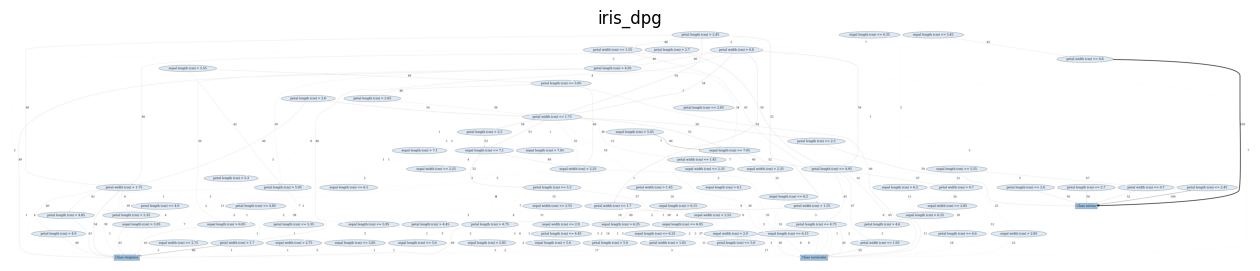

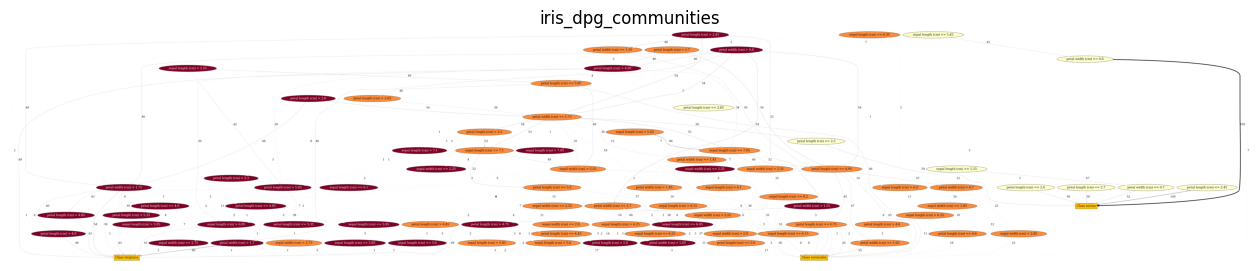

In [16]:
run_name = "iris_dpg"
explainer.plot(run_name, explanation, save_dir="results", class_flag=True, export_pdf=True)
explainer.plot_communities(run_name, explanation, save_dir="results", class_flag=True, export_pdf=True)


## 8. Practitioner Summary
Use these three points to tell the story:
- LRC: Which predicate most strongly frames the model’s logic?
- BC: Which predicate acts as a bottleneck between key decision paths?
- Communities: Which predicate groups define the themes of each class?